In [ ]:
!pip install -q kaggle 
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d bryanb/abstract-art-gallery
! unzip  abstract-art-gallery.zip

Saving kaggle.json to kaggle.json
 98% 681M/693M [00:10<00:00, 41.3MB/s]
100% 693M/693M [00:10<00:00, 67.0MB/s]
Archive:  abstract-art-gallery.zip
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_0.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_10.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_100.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1000.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1001.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1002.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1003.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1004.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1005.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1006.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_ima

In [ ]:
import os
import numpy as np
import torch
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch import nn, optim
from torchsummary import summary
from torchvision.utils import make_grid
from numpy.random import choice
from numpy.random import random


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

# example of smoothing class=1 to [0.7, 1.2]
def smooth_positive_labels(y):
	return y - 0.3 + (random(y.shape) * 0.5)
 
# example of smoothing class=0 to [0.0, 0.3]
def smooth_negative_labels(y):
	return y + random(y.shape) * 0.3

# invert the labels in place
def noisy_labels(y, p_flip):
	n_select = int(p_flip * y.shape[0])
	flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
	y[flip_ix] = 1 - y[flip_ix]
	return y

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
# path_list = []
# torch.manual_seed(10)
path = "/content/Abstract_gallery/"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:

norm=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
batch_size = 64
image_size = 64
transf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*norm,inplace=True),
    # AddGaussianNoise(0., 1.)
])

In [ ]:
from torchvision import datasets

dataset = datasets.ImageFolder(root=path,transform=transf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

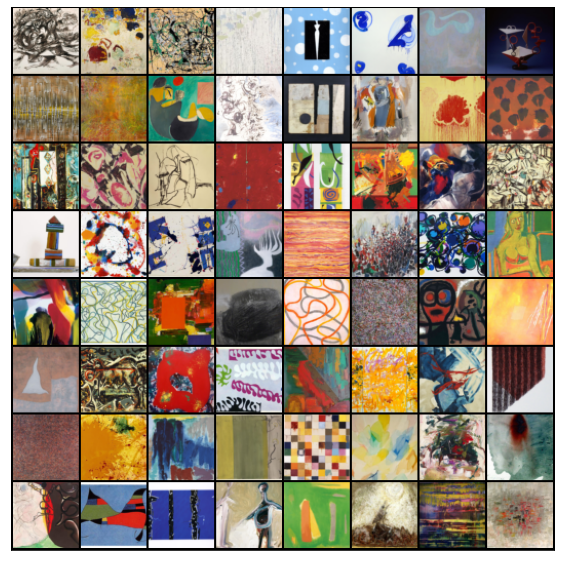

In [ ]:
for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, *norm)
        ax.imshow(make_grid(unnorm_images[:batch_size], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [ ]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            # nn.Dropout2d(0.2),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

generator = Generator()
generator.to(device)
generator.apply(weights_init)
summary(generator,(100,1,1),64,'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [64, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [64, 1024, 4, 4]           2,048
              ReLU-3           [64, 1024, 4, 4]               0
   ConvTranspose2d-4            [64, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [64, 512, 8, 8]           1,024
              ReLU-6            [64, 512, 8, 8]               0
   ConvTranspose2d-7          [64, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [64, 256, 16, 16]             512
              ReLU-9          [64, 256, 16, 16]               0
  ConvTranspose2d-10          [64, 128, 32, 32]         524,288
      BatchNorm2d-11          [64, 128, 32, 32]             256
             ReLU-12          [64, 128, 32, 32]               0
  ConvTranspose2d-13            [64, 3, 64, 64]           6,144
             Tanh-14            [64, 3,

In [ ]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

discriminator = Discriminator()
discriminator.to(device)
discriminator.apply(weights_init)
summary(discriminator,(3,64,64),64,'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 32, 32]           1,536
         LeakyReLU-2           [64, 32, 32, 32]               0
            Conv2d-3           [64, 64, 16, 16]          32,768
       BatchNorm2d-4           [64, 64, 16, 16]             128
         LeakyReLU-5           [64, 64, 16, 16]               0
            Conv2d-6            [64, 128, 8, 8]         131,072
       BatchNorm2d-7            [64, 128, 8, 8]             256
         LeakyReLU-8            [64, 128, 8, 8]               0
            Conv2d-9            [64, 256, 4, 4]         524,288
      BatchNorm2d-10            [64, 256, 4, 4]             512
        LeakyReLU-11            [64, 256, 4, 4]               0
           Conv2d-12              [64, 1, 1, 1]           4,096
          Sigmoid-13              [64, 1, 1, 1]               0
Total params: 694,656
Trainable params:

In [ ]:
loss = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch 1 >> Discriminator_Loss: 0.012299   Generator_Loss: 0.097017
Epoch 2 >> Discriminator_Loss: 0.005683   Generator_Loss: 0.087075
Epoch 3 >> Discriminator_Loss: 0.003849   Generator_Loss: 0.098486
Epoch 4 >> Discriminator_Loss: 0.013788   Generator_Loss: 0.048926
Epoch 5 >> Discriminator_Loss: 0.016937   Generator_Loss: 0.038520
Epoch 6 >> Discriminator_Loss: 0.008652   Generator_Loss: 0.060732
Epoch 7 >> Discriminator_Loss: 0.006773   Generator_Loss: 0.071363
Epoch 8 >> Discriminator_Loss: 0.008819   Generator_Loss: 0.048355
Epoch 9 >> Discriminator_Loss: 0.007869   Generator_Loss: 0.064695
Epoch 10 >> Discriminator_Loss: 0.006625   Generator_Loss: 0.078030
Epoch 11 >> Discriminator_Loss: 0.005755   Generator_Loss: 0.069029
Epoch 12 >> Discriminator_Loss: 0.008795   Generator_Loss: 0.067935
Epoch 13 >> Discriminator_Loss: 0.007009   Generator_Loss: 0.063471
Epoch 14 >> Discriminator_Loss: 0.005629   Generator_Loss: 0.067795
Epoch 15 >> Discriminator_Loss: 0.010014   Generator_Loss

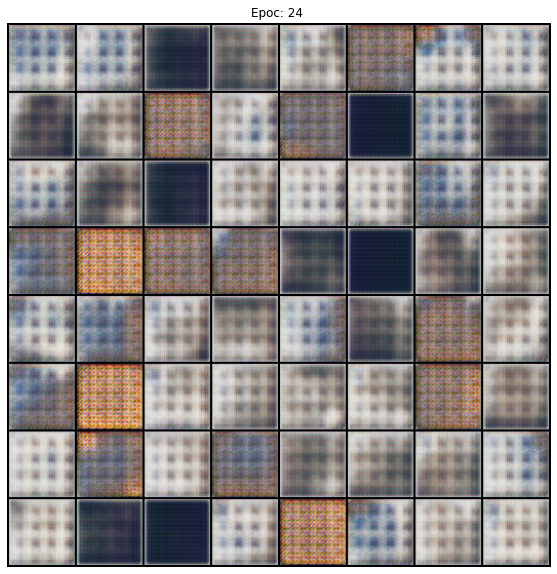

Epoch 26 >> Discriminator_Loss: 0.010481   Generator_Loss: 0.043481
Epoch 27 >> Discriminator_Loss: 0.011428   Generator_Loss: 0.046373
Epoch 28 >> Discriminator_Loss: 0.014762   Generator_Loss: 0.033042
Epoch 29 >> Discriminator_Loss: 0.016792   Generator_Loss: 0.033667
Epoch 30 >> Discriminator_Loss: 0.015891   Generator_Loss: 0.038999
Epoch 31 >> Discriminator_Loss: 0.013941   Generator_Loss: 0.048055
Epoch 32 >> Discriminator_Loss: 0.015345   Generator_Loss: 0.038822
Epoch 33 >> Discriminator_Loss: 0.014365   Generator_Loss: 0.042745
Epoch 34 >> Discriminator_Loss: 0.010478   Generator_Loss: 0.042864
Epoch 35 >> Discriminator_Loss: 0.014759   Generator_Loss: 0.041369
Epoch 36 >> Discriminator_Loss: 0.013754   Generator_Loss: 0.041321
Epoch 37 >> Discriminator_Loss: 0.011897   Generator_Loss: 0.043414
Epoch 38 >> Discriminator_Loss: 0.013728   Generator_Loss: 0.042674
Epoch 39 >> Discriminator_Loss: 0.015625   Generator_Loss: 0.038107
Epoch 40 >> Discriminator_Loss: 0.010649   Gener

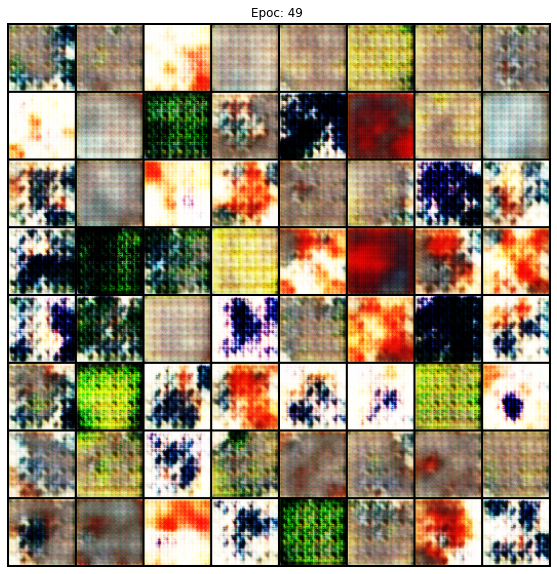

Epoch 51 >> Discriminator_Loss: 0.010030   Generator_Loss: 0.045667
Epoch 52 >> Discriminator_Loss: 0.009261   Generator_Loss: 0.050309
Epoch 53 >> Discriminator_Loss: 0.009017   Generator_Loss: 0.059327
Epoch 54 >> Discriminator_Loss: 0.007601   Generator_Loss: 0.055292
Epoch 55 >> Discriminator_Loss: 0.012252   Generator_Loss: 0.054056
Epoch 56 >> Discriminator_Loss: 0.013549   Generator_Loss: 0.042775
Epoch 57 >> Discriminator_Loss: 0.014596   Generator_Loss: 0.042253
Epoch 58 >> Discriminator_Loss: 0.012641   Generator_Loss: 0.043650
Epoch 59 >> Discriminator_Loss: 0.012454   Generator_Loss: 0.041736
Epoch 60 >> Discriminator_Loss: 0.015156   Generator_Loss: 0.037697
Epoch 61 >> Discriminator_Loss: 0.012362   Generator_Loss: 0.041129
Epoch 62 >> Discriminator_Loss: 0.013899   Generator_Loss: 0.042376
Epoch 63 >> Discriminator_Loss: 0.010910   Generator_Loss: 0.044703
Epoch 64 >> Discriminator_Loss: 0.013299   Generator_Loss: 0.042494
Epoch 65 >> Discriminator_Loss: 0.014451   Gener

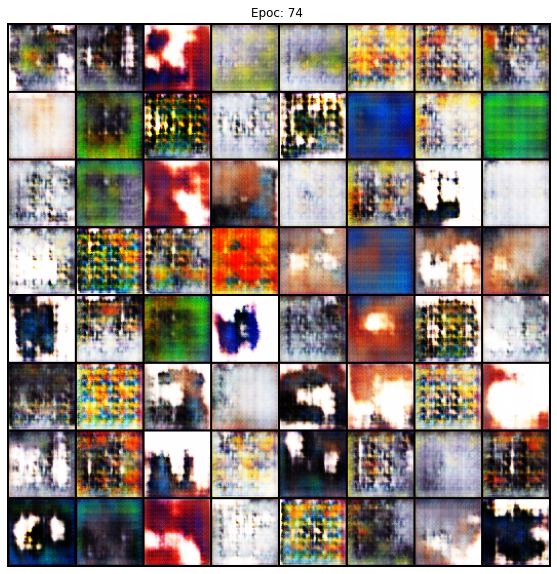

Epoch 76 >> Discriminator_Loss: 0.012443   Generator_Loss: 0.041966
Epoch 77 >> Discriminator_Loss: 0.012544   Generator_Loss: 0.042119
Epoch 78 >> Discriminator_Loss: 0.012417   Generator_Loss: 0.040385
Epoch 79 >> Discriminator_Loss: 0.010426   Generator_Loss: 0.041082
Epoch 80 >> Discriminator_Loss: 0.010606   Generator_Loss: 0.043452
Epoch 81 >> Discriminator_Loss: 0.011942   Generator_Loss: 0.043282
Epoch 82 >> Discriminator_Loss: 0.010597   Generator_Loss: 0.049198
Epoch 83 >> Discriminator_Loss: 0.012342   Generator_Loss: 0.046959
Epoch 84 >> Discriminator_Loss: 0.008992   Generator_Loss: 0.045570
Epoch 85 >> Discriminator_Loss: 0.009385   Generator_Loss: 0.046036
Epoch 86 >> Discriminator_Loss: 0.009755   Generator_Loss: 0.050127
Epoch 87 >> Discriminator_Loss: 0.009122   Generator_Loss: 0.048651
Epoch 88 >> Discriminator_Loss: 0.009724   Generator_Loss: 0.051282
Epoch 89 >> Discriminator_Loss: 0.010340   Generator_Loss: 0.048529
Epoch 90 >> Discriminator_Loss: 0.009381   Gener

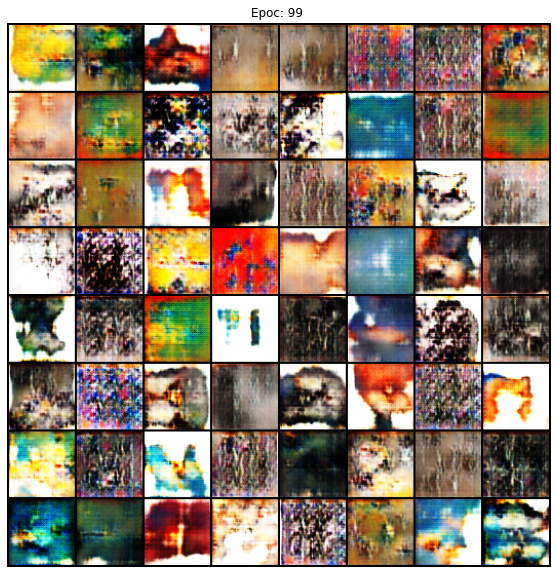

Epoch 101 >> Discriminator_Loss: 0.009809   Generator_Loss: 0.052218
Epoch 102 >> Discriminator_Loss: 0.008884   Generator_Loss: 0.052242
Epoch 103 >> Discriminator_Loss: 0.008307   Generator_Loss: 0.057019
Epoch 104 >> Discriminator_Loss: 0.006603   Generator_Loss: 0.052076
Epoch 105 >> Discriminator_Loss: 0.012568   Generator_Loss: 0.059661
Epoch 106 >> Discriminator_Loss: 0.007033   Generator_Loss: 0.045823
Epoch 107 >> Discriminator_Loss: 0.009227   Generator_Loss: 0.048113
Epoch 108 >> Discriminator_Loss: 0.011216   Generator_Loss: 0.047260
Epoch 109 >> Discriminator_Loss: 0.006616   Generator_Loss: 0.046375
Epoch 110 >> Discriminator_Loss: 0.008579   Generator_Loss: 0.051238
Epoch 111 >> Discriminator_Loss: 0.010658   Generator_Loss: 0.054380
Epoch 112 >> Discriminator_Loss: 0.008992   Generator_Loss: 0.050546
Epoch 113 >> Discriminator_Loss: 0.008301   Generator_Loss: 0.051841
Epoch 114 >> Discriminator_Loss: 0.009479   Generator_Loss: 0.051807
Epoch 115 >> Discriminator_Loss: 0

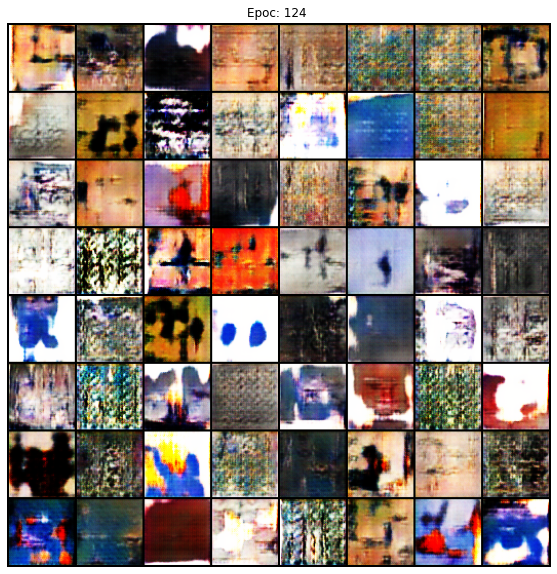

Epoch 126 >> Discriminator_Loss: 0.006783   Generator_Loss: 0.050374
Epoch 127 >> Discriminator_Loss: 0.006571   Generator_Loss: 0.050978
Epoch 128 >> Discriminator_Loss: 0.006199   Generator_Loss: 0.057323
Epoch 129 >> Discriminator_Loss: 0.012197   Generator_Loss: 0.055712
Epoch 130 >> Discriminator_Loss: 0.006830   Generator_Loss: 0.053182
Epoch 131 >> Discriminator_Loss: 0.006314   Generator_Loss: 0.052795
Epoch 132 >> Discriminator_Loss: 0.008432   Generator_Loss: 0.056759
Epoch 133 >> Discriminator_Loss: 0.009274   Generator_Loss: 0.055827
Epoch 134 >> Discriminator_Loss: 0.008388   Generator_Loss: 0.054256
Epoch 135 >> Discriminator_Loss: 0.006381   Generator_Loss: 0.052989
Epoch 136 >> Discriminator_Loss: 0.006931   Generator_Loss: 0.052859
Epoch 137 >> Discriminator_Loss: 0.006437   Generator_Loss: 0.055842
Epoch 138 >> Discriminator_Loss: 0.007824   Generator_Loss: 0.056402
Epoch 139 >> Discriminator_Loss: 0.009590   Generator_Loss: 0.055605
Epoch 140 >> Discriminator_Loss: 0

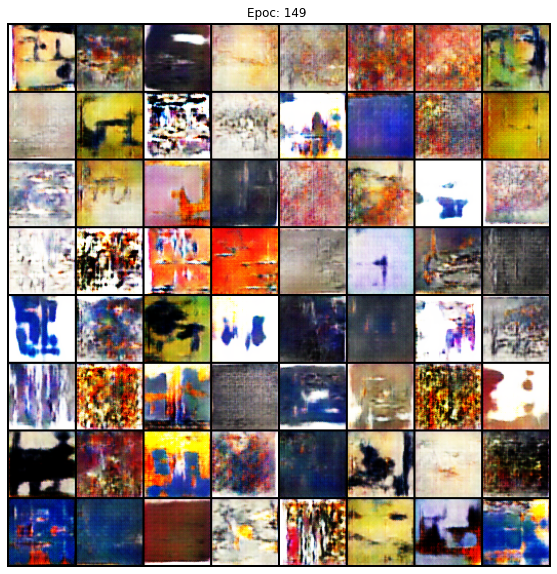

Epoch 151 >> Discriminator_Loss: 0.005201   Generator_Loss: 0.052951
Epoch 152 >> Discriminator_Loss: 0.007202   Generator_Loss: 0.055915
Epoch 153 >> Discriminator_Loss: 0.006828   Generator_Loss: 0.055883
Epoch 154 >> Discriminator_Loss: 0.013391   Generator_Loss: 0.057468
Epoch 155 >> Discriminator_Loss: 0.005961   Generator_Loss: 0.054439
Epoch 156 >> Discriminator_Loss: 0.004903   Generator_Loss: 0.055087
Epoch 157 >> Discriminator_Loss: 0.005736   Generator_Loss: 0.057556
Epoch 158 >> Discriminator_Loss: 0.007402   Generator_Loss: 0.057001
Epoch 159 >> Discriminator_Loss: 0.004159   Generator_Loss: 0.055175
Epoch 160 >> Discriminator_Loss: 0.006743   Generator_Loss: 0.058355
Epoch 161 >> Discriminator_Loss: 0.004963   Generator_Loss: 0.057093
Epoch 162 >> Discriminator_Loss: 0.007449   Generator_Loss: 0.062526
Epoch 163 >> Discriminator_Loss: 0.007478   Generator_Loss: 0.057617
Epoch 164 >> Discriminator_Loss: 0.005418   Generator_Loss: 0.056173
Epoch 165 >> Discriminator_Loss: 0

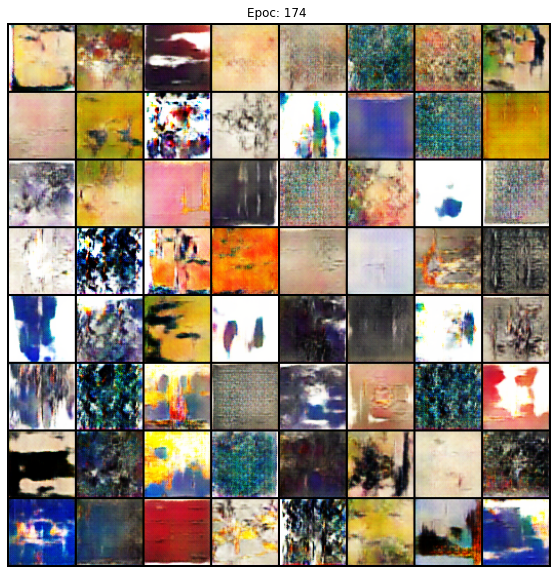

Epoch 176 >> Discriminator_Loss: 0.003551   Generator_Loss: 0.057400
Epoch 177 >> Discriminator_Loss: 0.004278   Generator_Loss: 0.058186
Epoch 178 >> Discriminator_Loss: 0.003484   Generator_Loss: 0.057916
Epoch 179 >> Discriminator_Loss: 0.004075   Generator_Loss: 0.060396
Epoch 180 >> Discriminator_Loss: 0.008691   Generator_Loss: 0.065260
Epoch 181 >> Discriminator_Loss: 0.006779   Generator_Loss: 0.060880
Epoch 182 >> Discriminator_Loss: 0.006614   Generator_Loss: 0.061756
Epoch 183 >> Discriminator_Loss: 0.004120   Generator_Loss: 0.060746
Epoch 184 >> Discriminator_Loss: 0.003324   Generator_Loss: 0.058434
Epoch 185 >> Discriminator_Loss: 0.004091   Generator_Loss: 0.060642
Epoch 186 >> Discriminator_Loss: 0.003816   Generator_Loss: 0.060653
Epoch 187 >> Discriminator_Loss: 0.007772   Generator_Loss: 0.064212
Epoch 188 >> Discriminator_Loss: 0.005198   Generator_Loss: 0.061462
Epoch 189 >> Discriminator_Loss: 0.004778   Generator_Loss: 0.062865
Epoch 190 >> Discriminator_Loss: 0

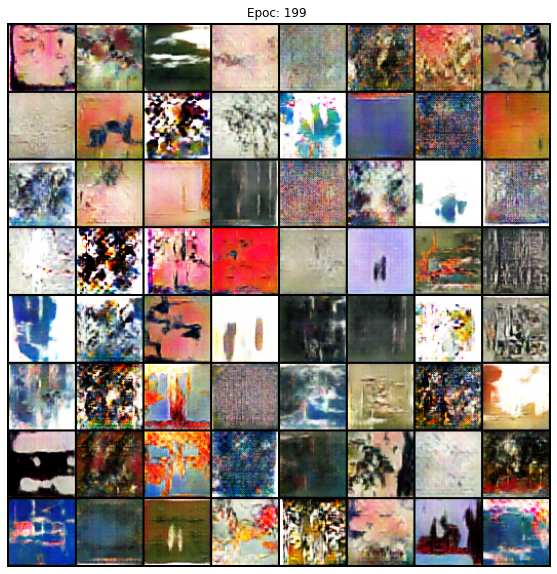

In [ ]:
import torchvision.utils as vutils

img_list = []
Gen_losses = []
Dis_losses = []
counter = 0
for epoch in range(200):
    gen_loss = 0.0
    dis_loss = 0.0
    total = 0
    for i, data in enumerate(dataloader, 0):
        # if counter % 10 == 0:
        ## Part1: train discriminator with real data and real lables
        discriminator.zero_grad()
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,),real_label, dtype=torch.float).to(device)
        # label = smooth_positive_labels(label).float().to(device)
        # label = noisy_labels(label,0.05).to(device)   ## Add some noise to real labels
        output = discriminator(real_data).view(-1)
        err_Dis_real = loss(output, label)
        err_Dis_real.backward()
        optimizerD.step()
        ## Part2: train discriminator with fake data and fake labels
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = generator(noise)
        label = torch.full((b_size,),fake_label, dtype=torch.float).to(device)
        # label = noisy_labels(label,0.05).to(device)   ## Add some noise to real labels
        # label = smooth_negative_labels(label).float().to(device)
        output = discriminator(fake.detach()).view(-1)
        err_Dis_fake = loss(output, label)
        err_Dis_fake.backward()
        Disc_err = err_Dis_real + err_Dis_fake
        optimizerD.step()

        ## Part3: train generator with fake data and real lables
        generator.zero_grad()
        label = torch.full((b_size,),real_label, dtype=torch.float).to(device)
        output = discriminator(fake).view(-1)
        errG = loss(output, label)
        errG.backward()
        optimizerG.step()

        gen_loss += errG.item()
        dis_loss += Disc_err.item()
        total += b_size

    counter = counter + 1    
    avg_dis_loss = dis_loss / total
    avg_gen_loss = gen_loss / total
    Dis_losses.append(avg_dis_loss)
    Gen_losses.append(avg_gen_loss)
    
    print('Epoch {} >> Discriminator_Loss: {:.6f}   Generator_Loss: {:.6f}'.format(
        epoch + 1,
        avg_dis_loss,
        avg_gen_loss,
    ))
    
    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(unnorm(fake, *norm), padding=2, normalize=True))

    if counter % 25 == 0:
        fig = plt.figure(figsize=(10,10))
        plt.axis("off")
        plt.title("Epoc: {} ".format(counter-1))
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.show()

In [14]:
torch.save(generator.state_dict(), 'G.pth')


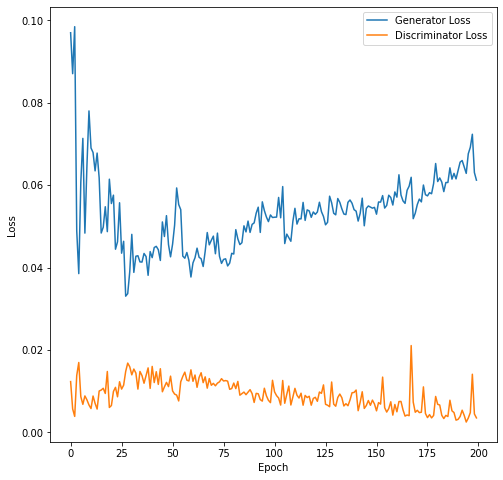

In [15]:
plt.figure(figsize=(8,8))
plt.plot(Gen_losses,label="Generator Loss")
plt.plot(Dis_losses,label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

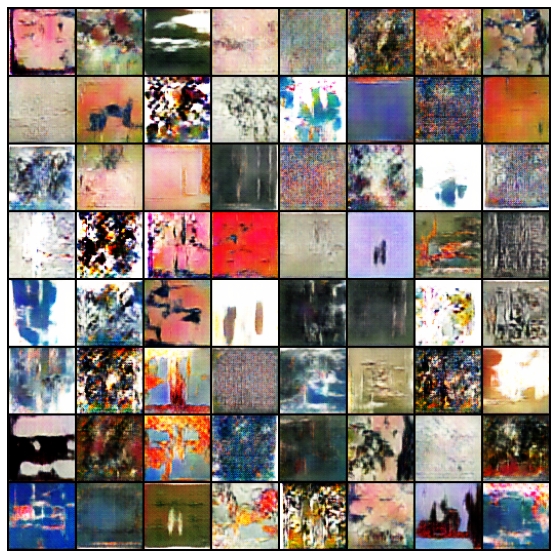

In [16]:
fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
